In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import xgboost as xgb

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy import sparse

from wordcloud import WordCloud

from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## read in the data

In [2]:
data = pd.read_csv('youtube-comments.csv')

In [3]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w


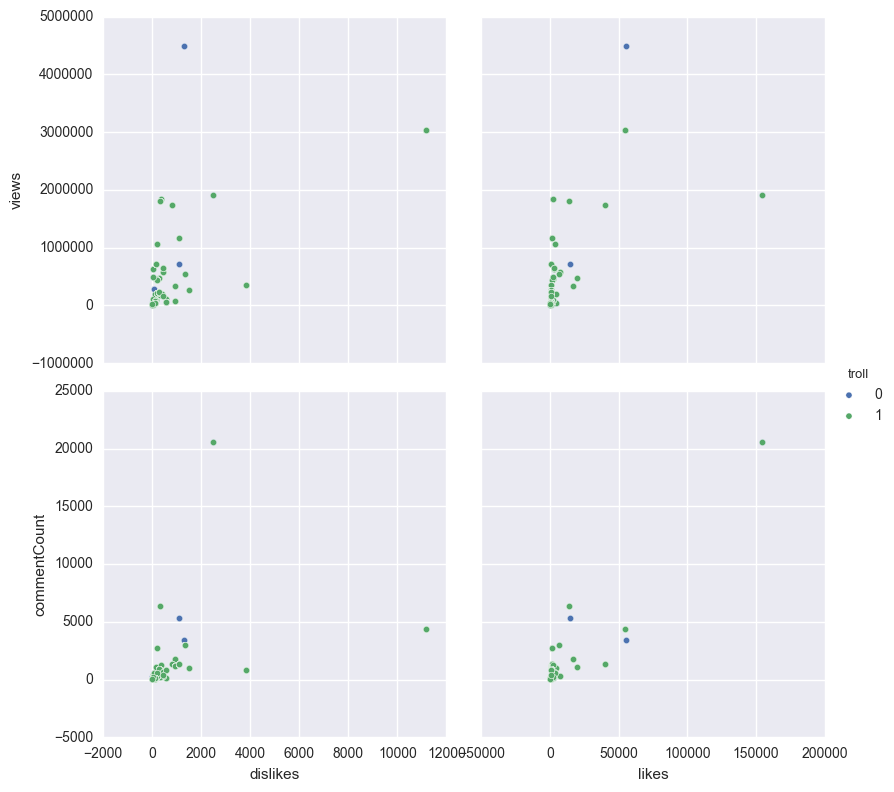

In [4]:
sns.pairplot(data=data, x_vars=['dislikes', 'likes'], y_vars=['views', 'commentCount'], hue='troll', size=4)

## cleaning the text

In [5]:
def cleaner(text, stem=True):
    '''Function to clean the text data and prep for further analysis'''
    stops = set(stopwords.words("english"))       # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                   # Creating the stemmer model
    text = re.sub("&#39;", '', text)               # removing '&#39;' that represents apastrophe
    text = re.sub("&quot;", '', text)             # removing '&quot;'
    text = re.sub(r"</?\w+[^>]*>", '', text)      # removing html tags
    text = re.sub(r'(.)\1+', r'\1\1', text)       # reducing the repeated letters to at most two
    text = re.sub("[^a-zA-Z@!0-9]", ' ', text)    # removing anythin other alpha-numerical char's and @ and !
    text = text.split()                          # Splits the data into individual words 
    text = [w for w in text if not w in stops]   # Removes stopwords
    if stem:
        text = [p_stemmer.stem(i) for i in text]     # Stemming (reducing words to their root)
    if not len(text):                            # dealing with comments that are all emojis, stop words or other languages
        text = ['emostwol']
    return ' '.join(text)

In [6]:
data['clean'] = data['comment'].apply(cleaner)

In [7]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id,clean
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,What lucki guy got celebr birthday concert bil...
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,Love
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,american even knew corden sever year ago
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,birthday 22nd well support west ham
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,OMG IM CRi


### word cloud for non troll comments

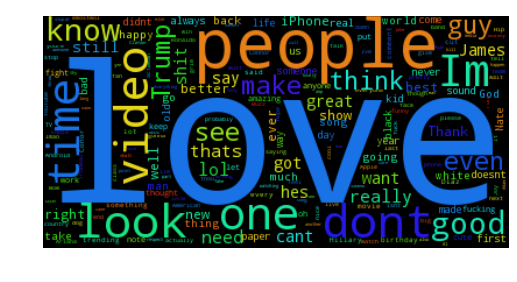

In [8]:
text_not_troll = ' '.join(data[data.troll==0].comment.apply(cleaner, stem=False))

# Generate a word cloud image
wordcloud_not_troll = WordCloud().generate(text_not_troll)

# Display the generated image:
plt.imshow(wordcloud_not_troll)
plt.axis("off")
plt.savefig('wordCloud.png')

### word cloud for troll comments

In [9]:
# text_troll = ' '.join(data[data.troll==1].comment.apply(cleaner, stem=False))

# # Generate a word cloud image
# wordcloud_troll = WordCloud().generate(text_troll)

# # Display the generated image:
# plt.imshow(wordcloud_troll)
# plt.axis("off")

## Building the pipeline

In [10]:
import inspect
inspect.signature(TfidfVectorizer)

<Signature (input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)>

In [11]:
class vectorizer(TfidfVectorizer):
    def __init__(self, 
                 input='content', 
                 encoding='utf-8', 
                 decode_error='strict', 
                 strip_accents=None, 
                 lowercase=True, 
                 preprocessor=None, 
                 tokenizer=None, 
                 analyzer='word', 
                 stop_words=None, 
                 token_pattern='(?u)\\b\\w\\w+\\b', 
                 ngram_range=(1, 1), 
                 max_df=1.0, 
                 min_df=1, 
                 max_features=None, 
                 vocabulary=None, 
                 binary=False,  
                 norm='l2', 
                 use_idf=True, 
                 smooth_idf=True, 
                 sublinear_tf=False):
        super().__init__(input='content', 
                         encoding='utf-8', 
                         decode_error='strict', 
                         strip_accents=None, 
                         lowercase=True, 
                         preprocessor=None, 
                         tokenizer=None, 
                         analyzer='word', 
                         stop_words=None, 
                         token_pattern='(?u)\\b\\w\\w+\\b', 
                         ngram_range=(1, 1), 
                         max_df=1.0, 
                         min_df=1, 
                         max_features=None, 
                         vocabulary=None, 
                         binary=False, 
                         norm='l2', 
                         use_idf=True, 
                         smooth_idf=True, 
                         sublinear_tf=False)

    def fit(self, df, y=None):
        X = df.clean
        return super().fit(X, y)

    def transform(self, df):  
        X = df.clean
        return super().transform(X)

In [12]:
class generate_video_stats(BaseEstimator):
    def __init__(self):
        pass

    def get_feature_names(self):
        return np.array(['views', 'dislikes', 'commentCount', 'likes', 'replies'])

    def fit(self, df, y=None):
        return self

    def transform(self, df):        
        output = df[['views', 'dislikes', 'commentCount', 'likes', 'replies']]
        return normalize(output, axis=0, norm='l2')

In [13]:
class text_feature_transformer(BaseEstimator):
    def __init__(self):
        with open("my_badlist3.txt") as f:
            badwords = [l.strip() for l in f.readlines()]
        self.badwords_ = badwords

    def get_feature_names(self):
        return np.array(['n_words', 'n_chars', 'allcaps', 'max_len',
            'mean_len', '@', '!', 'spaces', 'bad_ratio', 'n_bad',
            'capsratio'])

    def fit(self, df, y=None):
        return self

    def transform(self, df): 
        documents = df.clean
        ## some handcrafted features!
        n_words = [len(c.split()) for c in documents]
        n_chars = [len(c) for c in documents]
        # number of uppercase words
        allcaps = [np.sum([w.isupper() for w in c.split()])
               for c in documents]
        # longest word
        max_word_len = [np.max([len(w) for w in c.split()]) for c in (documents)]
        # average word length
        mean_word_len = [np.mean([len(w) for w in c.split()])
                                            for c in (documents)]
        # number of google badwords:
        n_bad = [np.sum([c.lower().count(w) for w in self.badwords_])
                                                for c in documents]
        exclamation = [c.count("!") for c in documents]
        addressing = [c.count("@") for c in documents]
        spaces = [c.count(" ") for c in documents]

        n_words[n_words==0] = 1
        allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
        bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)
        
        output = np.array([n_words, n_chars, allcaps, max_word_len,
            mean_word_len, exclamation, addressing, spaces, bad_ratio, n_bad,
            allcaps_ratio]).T

        return normalize(output, axis=0, norm='l2')

In [14]:
trans = text_feature_transformer()
data_trans = pd.DataFrame(trans.transform(data), columns=trans.get_feature_names())
data_trans['troll'] = data.troll

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C78DEF0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C7C9390>], dtype=object)

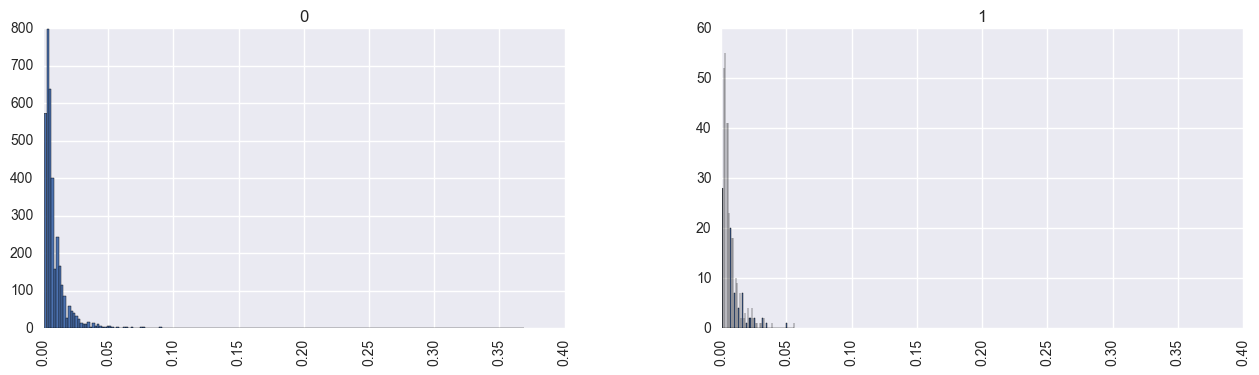

In [15]:
data_trans.hist(bins=200, column='n_words', by='troll', figsize=(15,4), sharex=True)

In [16]:
class feature_stacker(BaseEstimator):
    """Stacks several transformer objects to yield concatenated features.
    Similar to pipeline, a list of tuples ``(name, estimator)`` is passed
    to the constructor.
    """
    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def get_feature_names(self):
        feature_names = []
        for name, trans in self.transformer_list:
            feature_names.extend(trans.get_feature_names())
        feature_names = [" ".join(w) if isinstance(w, tuple) else w
                            for w in feature_names]
        return np.array(feature_names)

    def fit(self, X, y=None):
        for name, trans in self.transformer_list:
            trans.fit(X, y)
        return self

    def transform(self, X):
        features = []
        for name, trans in self.transformer_list:
            features.append(trans.transform(X))
        issparse = [sparse.issparse(f) for f in features]
        if np.any(issparse):
            features = sparse.hstack(features).tocsr()
        else:
            features = np.hstack(features)
        return features

    def get_params(self, deep=True):
        if not deep:
            return super(feature_stacker, self).get_params(deep=False)
        else:
            out = dict(self.transformer_list)
            for name, trans in self.transformer_list:
                for key, value in trans.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [17]:
vectorizer_word = vectorizer(lowercase=False,
                             analyzer=u'word',
                             ngram_range=(1, 3),
                             stop_words='english',
                             binary=False,
                             norm=u'l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True,
                             min_df=3)

In [18]:
vectorizer_char = vectorizer(lowercase=False,
                             analyzer=u'char',
                             ngram_range=(1, 5),
                             stop_words='english',
                             binary=False,
                             norm=u'l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True)

In [19]:
select = SelectPercentile(score_func=chi2, percentile=1)

In [20]:
clf = LogisticRegression(tol=1e-8, penalty='l2', C=8, class_weight='balanced')

In [21]:
tft = text_feature_transformer()

In [22]:
vs = generate_video_stats()

In [23]:
ft = feature_stacker([("text", tft), 
                      ("chars", vectorizer_char),
                      ("words", vectorizer_word),
                      ("stats", vs)])

In [24]:
model = Pipeline([('vect', ft), ('select', select), ('logr', clf)])

## creating labels

In [25]:
le = LabelEncoder()
le.fit(data.troll.values)
Y = le.transform(data.troll.values) 

## doing a grid search

GridSearchCV is really slow on my machine, need a proper GPU to run this properly, so trying to do the search by hand

In [26]:
parameters = {
    'vect__chars__ngram_range': ((1, 2), (1, 4), (1,5), (1,6)),  ###best (1,5)
    #'vect__words__ngram_range': ((1, 1), (1, 2), (1,3), (1,4)),  ###best (1,1)
    #'vect__words__use_idf': (True, False), ###best False
    #'vect__words__norm': ('l1', 'l2'), ###best l2
    #'select__percentile': (0.1, 1, 10, 20, 30), ###best 10
    #'logr__C': (1, 6, 7, 8, 9, 10, 15, 30) ###best 9
}

In [27]:
# model.get_params()

In [28]:
%%time

num_trials = 5
for i, param_key in enumerate(parameters):
    for param_value in parameters[param_key]:
        print('parameter {} = {}'.format(param_key, param_value))
        fscore = np.zeros(num_trials)
        for j in range(num_trials):
            X_train, X_test, y_train, y_test = train_test_split(data, Y, train_size=.80)
            pred = model.set_params(vect__chars__ngram_range=param_value).fit(X_train,y_train).predict(X_test)
            fscore[j] = f1_score(pred, y_test)
        print(np.mean(fscore))

parameter vect__chars__ngram_range = (1, 2)
0.499800281013
parameter vect__chars__ngram_range = (1, 4)
0.50514499283
parameter vect__chars__ngram_range = (1, 5)
0.520913492927
parameter vect__chars__ngram_range = (1, 6)
0.51684622643
Wall time: 53.1 s


## applying the pipeline with optimum values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, train_size=.80)

In [30]:
pred = model.set_params(vect__chars__ngram_range=(1,4),
                        vect__words__ngram_range=(1,3),
                        vect__words__use_idf=False,
                        vect__words__norm='l2',
                        select__percentile=10,
                        logr__C=9).fit(X_train,y_train).predict(X_test)

In [31]:
print('f1 score:')
print(f1_score(y_test, pred))
print('confusion matrix:')
print(confusion_matrix(y_test, pred))
print('log loss:')
print(log_loss(y_test, pred))

f1 score:
0.552941176471
confusion matrix:
[[664  31]
 [ 45  47]]
log loss:
3.33541523956


In [32]:
clf_labels = model.predict(data)
print('True Positives:')
print('================')
print(data['comment'][(clf_labels==1) & (data.troll==1)])
print('False Positives:')
print('================')
print(data['comment'][(clf_labels==1) & (data.troll==0)])
print('False Negatives:')
print('================')
print(data['comment'][(clf_labels==0) & (data.troll==1)])

True Positives:
13      wot a surprise can&#39;t get away from his cub...
17      This clown is like shit on a field. Unfunny fa...
57                                         fecking awful﻿
84                                 What a bunch of cunts﻿
94           James cordens stylist 😂 fucking state of it﻿
229     6 months? ...fuck that. At least give people a...
236       ehhh fine...i&#39;ll give ya a like..assholes.﻿
257     Don&#39;t agree with the gluten free one. Fuck...
259                  kys college humor you&#39;re cancer﻿
307                                        cheating scum﻿
308                                               nigger﻿
322                            FUCK YOU CHINA WE GOT 2ND﻿
331       was that good for a blackman chucking a spear?﻿
339     this nigga was the cause of my dad getting &qu...
380                                   Well that was shit﻿
383     how the fuck was that even amazing? he threw i...
464              Another shitty female lead action movie

### visualising the top 100 important features

In [33]:
coef_ = model.named_steps['logr'].coef_
important = np.argsort(np.abs(coef_.ravel()))[-100:]
feature_names = ft.get_feature_names()
f_imp = feature_names[important]
coef = coef_.ravel()[important]
inds = np.argsort(coef)
f_imp = f_imp[inds]
coef = coef[inds]

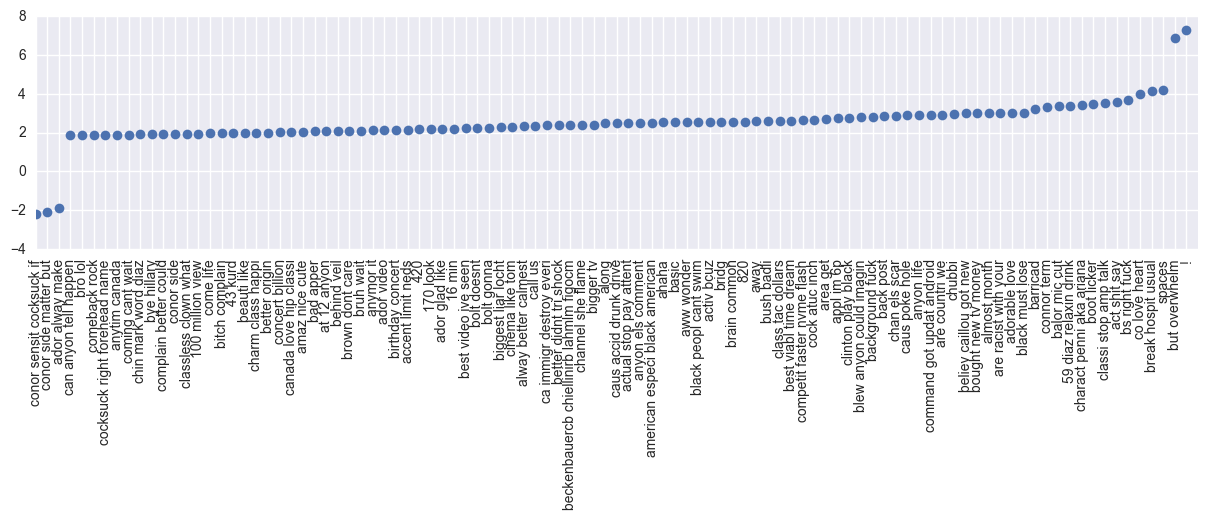

In [34]:
fig = plt.figure(figsize=(15,3))
ax = plt.gca()
ax.plot(coef, 'o')
ax.set_xticks(np.arange(len(coef)))
labels = ax.set_xticklabels(f_imp)
for label in labels:
    label.set_rotation(90)

In [35]:
X = ft.transform(data)
X = select.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)

In [36]:
##################
#     XGBoost
##################

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 6,
    "eval_metric": "logloss",
    "eta": 0.1,
    "silent": 1,
    "alpha": 3,
}
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, 40, evals=watchlist, verbose_eval=True)

[0]	train-logloss:0.619767	eval-logloss:0.623009
[1]	train-logloss:0.559933	eval-logloss:0.566312
[2]	train-logloss:0.509705	eval-logloss:0.517602
[3]	train-logloss:0.467275	eval-logloss:0.477225
[4]	train-logloss:0.430882	eval-logloss:0.443007
[5]	train-logloss:0.399787	eval-logloss:0.413256
[6]	train-logloss:0.372819	eval-logloss:0.387887
[7]	train-logloss:0.349226	eval-logloss:0.365919
[8]	train-logloss:0.328816	eval-logloss:0.346454
[9]	train-logloss:0.310478	eval-logloss:0.329607
[10]	train-logloss:0.29437	eval-logloss:0.31487
[11]	train-logloss:0.280094	eval-logloss:0.301794
[12]	train-logloss:0.267728	eval-logloss:0.290743
[13]	train-logloss:0.256542	eval-logloss:0.280957
[14]	train-logloss:0.246718	eval-logloss:0.272309
[15]	train-logloss:0.237921	eval-logloss:0.264819
[16]	train-logloss:0.23026	eval-logloss:0.257843
[17]	train-logloss:0.223165	eval-logloss:0.251636
[18]	train-logloss:0.216684	eval-logloss:0.246018
[19]	train-logloss:0.210778	eval-logloss:0.240877
[20]	train-lo

In [41]:
pred = gbm.predict(xgb.DMatrix(X_test))>0.3
print('f1 score:')
print(f1_score(y_test, pred))
print('confusion matrix:')
print(confusion_matrix(y_test, pred))
print('log loss:')
print(log_loss(y_test, pred))

f1 score:
0.545454545455
confusion matrix:
[[675  34]
 [ 36  42]]
log loss:
3.07209851837


# Questions/ comments
* does it make sense to do variance based feature selection when dealing with imbalanced label sizes?
* tf-idf vectorizer gives around 5500 words (columns) and that's more than the number of rows, and since most words are redundant anyway it is important to reduce the dimensionality of the problem
* the fact that only 10% of the data is trolls means that maybe an anamoly detection approach would perform better, this is taken care of by giving the classifier the flag class_weight='balanced' that ensures a balanced sampling of the input data
* use reg experssions to remove obvious things like links, etc
* do setiment analysis as an extra feature
* LogReg seems to perform better than RandForest, esp given the mismatch in label size
* I dont quite agree with some of the labels, part of the problem might be the fact that the labeling is not done in a consistent way